In [36]:
import lasagne
import numpy as np
import matplotlib.pyplot as plt

from robo.initial_design.init_random_uniform import init_random_uniform
from robo.models.dngo import DNGO
from robo.util.normalization import zero_mean_unit_var_normalization, zero_mean_unit_var_unnormalization


def f(x):
    return np.sinc(x * 10 - 5).sum(axis=1)[:, None]

rng = np.random.RandomState(42)

X = init_random_uniform(np.zeros(1), np.ones(1), 4, rng)
y = f(X)[:, 0]


model = DNGO(num_epochs=1000, do_mcmc=False, batch_size=10, n_hypers=50)


In [37]:
model.nll = model.negative_mll
model.train(X, y)


Optimization terminated successfully.
         Current function value: 149.360720
         Iterations: 154
         Function evaluations: 307


In [38]:
predictions = lasagne.layers.get_output(model.network,
                                        zero_mean_unit_var_normalization(X, model.X_mean, model.X_std)[0],
                                        deterministic=True).eval()

In [43]:
next(model.iterate_minibatches(model.X, model.y, batchsize=10))

StopIteration: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


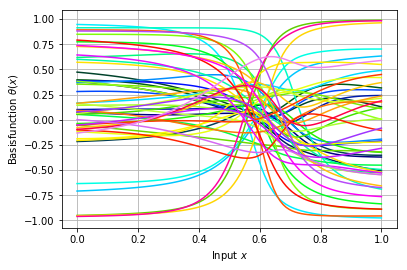

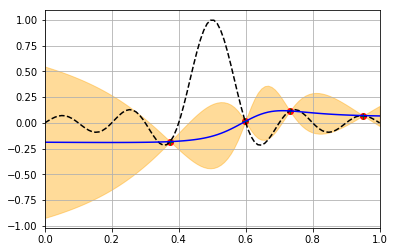

In [39]:

predictions = lasagne.layers.get_output(model.network,
                                        zero_mean_unit_var_normalization(X, model.X_mean, model.X_std)[0],
                                        deterministic=True).eval()

predictions = zero_mean_unit_var_unnormalization(predictions, model.y_mean, model.y_std)

X_test = np.linspace(0, 1, 100)[:, None]
X_test_norm = zero_mean_unit_var_normalization(X_test, model.X_mean, model.X_std)[0]

# Get features from the net
layers = lasagne.layers.get_all_layers(model.network)
basis_funcs = lasagne.layers.get_output(layers[:-1], X_test_norm)[-1].eval()

model.prior = None

fvals = f(X_test)[:, 0]

m, v = model.predict(X_test)

colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, min(50, model.n_units_3))])

for f in range(min(50, model.n_units_3)):
    plt.plot(X_test[:, 0], basis_funcs[:, f])
plt.grid()
plt.xlabel(r"Input $x$")
plt.ylabel(r"Basisfunction $\theta(x)$")
plt.show()


plt.plot(X, y, "ro")
plt.plot(X, predictions, "g+")
plt.grid()
plt.plot(X_test[:, 0], fvals, "k--")
plt.plot(X_test[:, 0], m, "blue")
plt.fill_between(X_test[:, 0], m + np.sqrt(v), m - np.sqrt(v), color="orange", alpha=0.4)
plt.xlim(0, 1)
plt.show()



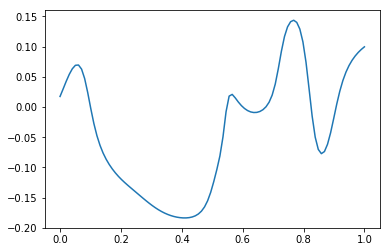

In [173]:
plt.plot(X_test, predictions)

In [171]:
model.models[0].alpha

0.0067379470136298344

In [172]:
model.models[0].beta

2544.0540587019664

In [69]:
r = model.models[0]
r.alpha, r.beta

(0.0081281351728166758, 0.99949890211574011)

In [ ]:
import numpy as np

from robo.fmin import bayesian_optimization
def objective_function(x):
    y = np.sin(3 * x[0]) * 4 * (x[0] - 1) * (x[0] + 2)
    return y

lower = np.array([0])
upper = np.array([6])

In [2]:

# GP solution
results = bayesian_optimization(objective_function, lower, upper, num_iterations=50)

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/usr/local/lib/python3.6/dist-packages/RoBO-0.2.2-py3.6.egg/robo/models/gaussian_process_mcmc.py", line 201, in loglikelihood
    return self.prior.lnprob(theta) + self.gp.lnlikelihood(self.y, quiet=True)
  File "/usr/local/lib/python3.6/dist-packages/RoBO-0.2.2-py3.6.egg/robo/priors/default_priors.py", line 31, in lnprob
    lp += self.ln_prior.lnprob(theta[0])
  File "/usr/local/lib/python3.6/dist-packages/RoBO-0.2.2-py3.6.egg/robo/priors/base_prior.py", line 278, in lnprob
    return sps.lognorm.logpdf(theta, self.sigma, loc=self.mean)
  File "/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py", line 1704, in logpdf
    place(output, cond, self._logpdf(*goodargs) - log(scale))
  File "/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py", line 3839, in _logpdf
 

emcee: Exception while calling your likelihood function:
  params: [  0.3864543   -4.39120239 -19.84441156]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:

# bohamiann
from robo.fmin import bohamiann
results = bohamiann(objective_function, lower, upper, num_iterations=50)


In [ ]:

# Benchmarks
from hpolib.benchmarks.synthetic_functions import Branin
f = Branin()
info = f.get_meta_information()
bounds = np.array(info['bounds'])
results = bayesian_optimization(f, bounds[:, 0], bounds[:, 1], num_iterations=50)


In [7]:

# Training BNN 
import matplotlib.pyplot as plt
import numpy as np

from robo.models.bnn import BayesianNeuralNetwork
from robo.initial_design.init_random_uniform import init_random_uniform

rng = np.random.RandomState(np.random.randint(0, 10000))

def f(x):
    return np.sinc(x * 10 - 5).sum(axis=1)

X = init_random_uniform(np.zeros(1), np.ones(1), 20, rng)
y = f(X)

model = BayesianNeuralNetwork(sampling_method="sghmc",
                              l_rate=np.sqrt(1e-4),
                              mdecay=0.05,
                              burn_in=3000,
                              n_iters=50000,
                              precondition=True,
                              normalize_input=True,
                              normalize_output=True)
model.train(X, y)

x = np.linspace(0, 1, 100)[:, None]
mean_pred, var_pred = model.predict(x)


... compiling theano function
... compiling theano function
